# Torches

In [10]:
from mip import *
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def neighs(i, j, n, m):
    x = list()
    
    if i > 0:
        x.append((i-1, j))
    if i < (n-1):
        x.append((i+1, j))
    if j > 0:
        x.append((i, j-1))
    if j < (m-1):
        x.append((i, j+1))
        
    return x

# TODO: Blocks are not transparent...
#       Ignore blocks
#       Add them back when plotting
#       => less variables and conditions

def torches(rows, cols, minv, maxv, blocks=[], verbose=True):
    m = Model()
    possibilities = [(i,j) for i in range(rows) for j in range(cols) if (i,j) not in blocks]
    nn = {(i,j): [x for x in neighs(i, j, rows, cols) if x not in blocks] for i,j in possibilities}

    level = {k: m.add_var(var_type=INTEGER, lb=minv, ub=maxv) for k in possibilities}
    torch = {k: m.add_var(var_type=BINARY) for k in possibilities}
    max_neighbor = {k: m.add_var(var_type=INTEGER, lb=minv, ub=maxv) for k in possibilities}
    which_neighbor = {(i,j,k): m.add_var(var_type=BINARY) for i,j in possibilities for k in range(len(nn[(i,j)]))}
    sol = m.add_var()
      
    # Find max neighbor
    for i,j in possibilities:        
        for k in range(len(nn[(i,j)])):
            a, b = nn[(i,j)][k]
            m += max_neighbor[(i,j)] >= level[(a,b)]
            m += max_neighbor[(i,j)] <= level[(a,b)] + (1 - which_neighbor[(i,j,k)])*maxv
        m += xsum(which_neighbor[(i,j,k)] for k in range(len(nn[(i,j)]))) == 1
            
    # If torch then maxv else max(neighbor) - 1
    for k in possibilities:
        m += level[k] - max_neighbor[k] + 1 >= 0
        m += level[k] - max_neighbor[k] + 1 <= 2 * torch[k]
        m += maxv - level[k] >= 0
        m += maxv - level[k] <= (1 - torch[k])*(maxv-minv)
    
    # Solution
    m += sol == xsum(torch[k] for k in possibilities)
    m.objective = sol
    
    m.emphasis = 2
    m.cuts = 3
    m.max_seconds = 100
    status = m.optimize()
    
    if verbose:
        if status == OptimizationStatus.OPTIMAL:
            print('optimal solution cost {} found'.format(m.objective_value))
        elif status == OptimizationStatus.FEASIBLE:
            print('sol.cost {} found, best possible: {}'.format(m.objective_value, m.objective_bound))
        elif status == OptimizationStatus.NO_SOLUTION_FOUND:
            print('no feasible solution found, lower bound is: {}'.format(m.objective_bound))
        elif status == OptimizationStatus.INFEASIBLE:
            print('INFEASIBLE'.format(m.objective_bound))
    return m

In [41]:
def plot(m, rows, cols, blocks):
    A = np.zeros((rows,cols))
    B = np.zeros((rows,cols))
    const = rows*cols-len(blocks)
    
    ind = 0
    ptr = 0
    while ind < rows*cols:
        i = ind // cols
        j = ind % cols
    
        if (i,j) in blocks:
            A[i][j] = -1
            B[i][j] = 0
            
        else:
            A[i][j] = m.vars[ptr+const].x
            B[i][j] = m.vars[ptr].x
            ptr += 1
            
        ind += 1
        
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].imshow(A)
    axes[0].set_title("Tochas")

    axes[1].imshow(B)
    plt.title("Luz")
    
    for i in range(rows):
        for j in range(cols):
            text = axes[1].text(j, i, B[i][j], ha="center", va="center", color="w")
    
    plt.show()

optimal solution cost 2.0 found


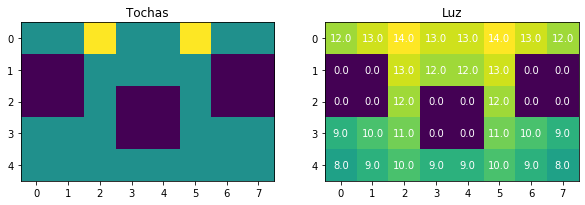

In [45]:
rows, cols = 5, 8
minv, maxv = 8, 14
blocks = [(2,4),(3,4),(2,3),(3,3),
          (1,0),(1,1),(2,0),(2,1),
          (1,7),(1,6),(2,7),(2,6)]

m = torches(rows, cols, minv, maxv, blocks)
plot(m, rows, cols, blocks)